# Simulating long experiments

This notebook introduces functionality for simulating experiments over hundreds or even thousands of cycles. 

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Simulating long experiments

In the interest of simplicity and running time, we consider a SPM with SEI effects leading to linear degradation, with parameter values chosen so that the capacity fades by 20% in just a few cycles

In [2]:
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

We initialize the concentration in each electrode at 100% State of Charge

In [3]:
# Calculate stoichiometries at 100% SOC
parameter_values.set_initial_stoichiometries(1);

We can now simulate a single CCCV cycle using the `Experiment` class (see [this notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Getting%20Started/Tutorial%205%20-%20Run%20experiments.ipynb) for more details)

In [4]:
pybamm.set_logging_level("NOTICE")

experiment = pybamm.Experiment([
    (f"Discharge at 1C until 3V",
     "Rest for 1 hour",
     f"Charge at 1C until 4.2V", 
     f"Hold at 4.2V until C/50"
    )
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2022-12-04 21:24:29.130 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (24.500 us elapsed) --------------------
2022-12-04 21:24:29.131 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:29.172 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Rest for 1 hour
2022-12-04 21:24:29.199 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2022-12-04 21:24:29.237 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2022-12-04 21:24:29.372 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 241.861 ms


Alternatively, we can simulate many CCCV cycles. Here we simulate either 100 cycles or until the capacity is 80% of the initial capacity, whichever is first. The capacity is calculated by the eSOH model

In [5]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until 3V",
     "Rest for 1 hour",
    f"Charge at 1C until 4.2V", 
    f"Hold at 4.2V until C/50")
] * 500,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2022-12-04 21:24:30.209 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/500 (25.250 us elapsed) --------------------
2022-12-04 21:24:30.209 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:30.248 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 2/4: Rest for 1 hour
2022-12-04 21:24:30.275 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2022-12-04 21:24:30.315 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2022-12-04 21:24:30.460 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-12-04 21:24:30.460 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/500 (251.525 ms elapsed) --------------------
2022-12-04 21:24:30.461 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:30.486 - [NOTICE] callbacks.on_step_start(182): Cycle 2/

### Summary variables

We can plot standard variables like the current and voltage, but it isn't very instructive on these timescales

In [6]:
sol.plot(["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=147.0821107778435, step=1.470821107778435), …

Instead, we plot "summary variables", which show how the battery degrades over time by various metrics. Some of the variables also have "Change in ...", which is how much that variable changes over each cycle. This can be achieved by using `plot_summary_variables` method of pybamm, which can also be used to compare "summary variables" extracted from 2 or more solutions.

In [7]:
sorted(sol.summary_variables.keys())

['Capacity [A.h]',
 'Change in local ECM resistance [Ohm]',
 'Change in loss of active material in negative electrode [%]',
 'Change in loss of active material in positive electrode [%]',
 'Change in loss of capacity to SEI [A.h]',
 'Change in loss of capacity to SEI on cracks [A.h]',
 'Change in loss of capacity to lithium plating [A.h]',
 'Change in loss of lithium inventory [%]',
 'Change in loss of lithium inventory, including electrolyte [%]',
 'Change in loss of lithium to SEI [mol]',
 'Change in loss of lithium to SEI on cracks [mol]',
 'Change in loss of lithium to lithium plating [mol]',
 'Change in negative electrode capacity [A.h]',
 'Change in positive electrode capacity [A.h]',
 'Change in throughput capacity [A.h]',
 'Change in throughput energy [W.h]',
 'Change in time [h]',
 'Change in time [s]',
 'Change in total capacity lost to side reactions [A.h]',
 'Change in total lithium [mol]',
 'Change in total lithium in electrolyte [mol]',
 'Change in total lithium in negati

The "summary variables" associated with a particular model can also be accessed as a list (which can then be edited) -

In [8]:
spm.summary_variables

['Time [s]',
 'Time [h]',
 'Throughput capacity [A.h]',
 'Throughput energy [W.h]',
 'Loss of lithium inventory [%]',
 'Loss of lithium inventory, including electrolyte [%]',
 'Total lithium [mol]',
 'Total lithium in electrolyte [mol]',
 'Total lithium in particles [mol]',
 'Total lithium lost [mol]',
 'Total lithium lost from particles [mol]',
 'Total lithium lost from electrolyte [mol]',
 'Loss of lithium to SEI [mol]',
 'Loss of capacity to SEI [A.h]',
 'Total lithium lost to side reactions [mol]',
 'Total capacity lost to side reactions [A.h]',
 'Local ECM resistance [Ohm]',
 'Negative electrode capacity [A.h]',
 'Loss of active material in negative electrode [%]',
 'Total lithium in negative electrode [mol]',
 'Loss of lithium to lithium plating [mol]',
 'Loss of capacity to lithium plating [A.h]',
 'Loss of lithium to SEI on cracks [mol]',
 'Loss of capacity to SEI on cracks [A.h]',
 'Positive electrode capacity [A.h]',
 'Loss of active material in positive electrode [%]',
 'Tot

Here the only degradation mechanism is one that causes loss of lithium, so we don't see loss of active material

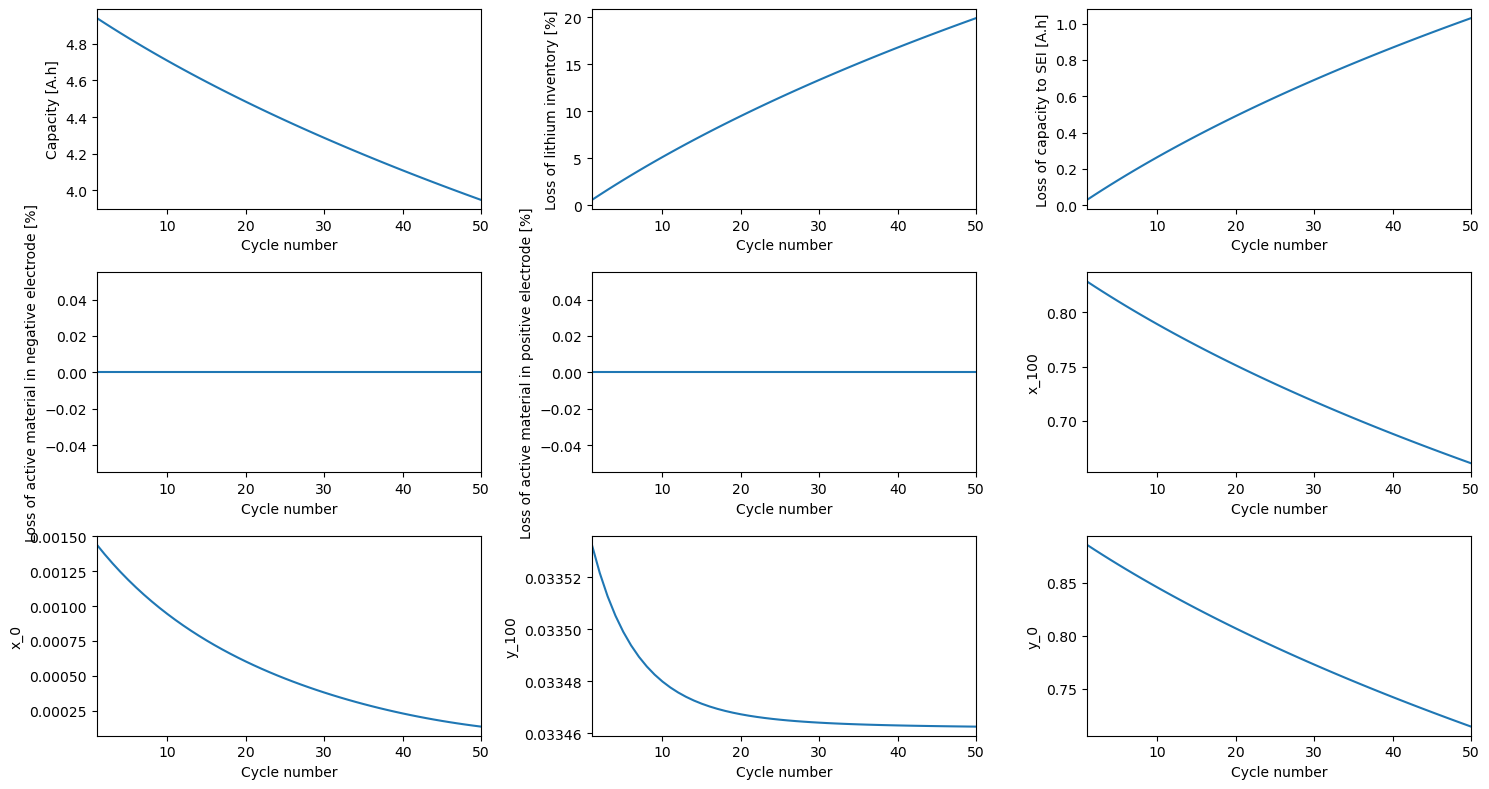

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [9]:
pybamm.plot_summary_variables(sol)

To suggest additional summary variables, open an issue!

## Choosing which cycles to save

If the simulation contains thousands of cycles, saving each cycle in RAM might not be possible. To get around this, we can use `save_at_cycles`. If this is an integer `n`, every nth cycle is saved. If this is a list, all the cycles in the list are saved.
The first cycle is always saved.

In [10]:
# With integer
sol_int = sim.solve(save_at_cycles=5)
# With list
sol_list = sim.solve(save_at_cycles=[30,45,55])

2022-12-04 21:24:37.738 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/500 (18.250 us elapsed) --------------------
2022-12-04 21:24:37.739 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:37.779 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 2/4: Rest for 1 hour
2022-12-04 21:24:37.793 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2022-12-04 21:24:37.813 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2022-12-04 21:24:37.855 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-12-04 21:24:37.855 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/500 (117.477 ms elapsed) --------------------
2022-12-04 21:24:37.856 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:37.879 - [NOTICE] callbacks.on_step_start(182): Cycle 2/

In [11]:
sol_int.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [12]:
sol_list.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

For the cycles that are saved, you can plot as usual (note off-by-1 indexing)

In [13]:
sol_list.cycles[44].plot(["Current [A]","Voltage [V]"])

interactive(children=(FloatSlider(value=130.34824962859955, description='t', max=133.15185653882043, min=130.3…

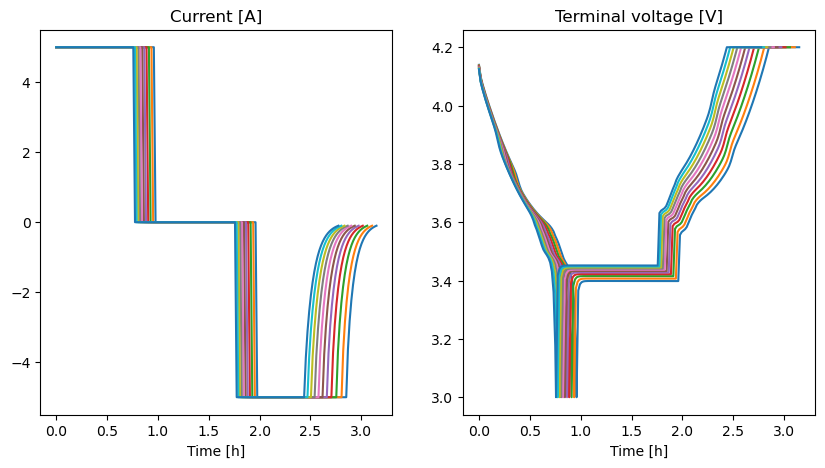

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for cycle in sol_int.cycles:
    if cycle is not None:
        t = cycle["Time [h]"].data - cycle["Time [h]"].data[0]
        ax[0].plot(t, cycle["Current [A]"].data)
        ax[0].set_xlabel("Time [h]")
        ax[0].set_title("Current [A]")
        ax[1].plot(t, cycle["Voltage [V]"].data)
        ax[1].set_xlabel("Time [h]")
        ax[1].set_title("Voltage [V]")

All summary variables are always available for every cycle, since these are much less memory-intensive

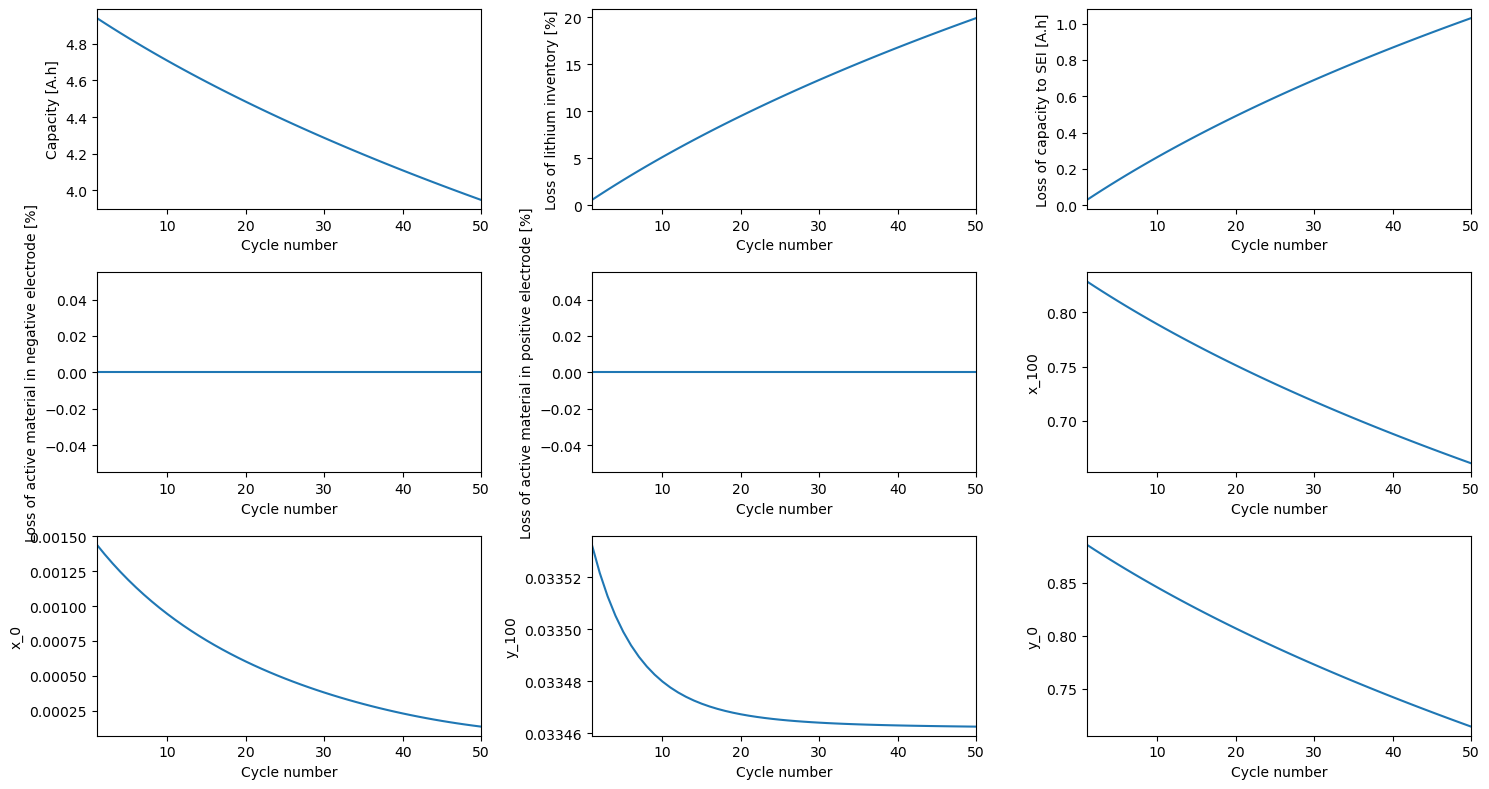

array([[<AxesSubplot:xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot:xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot:xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [15]:
pybamm.plot_summary_variables(sol_list)

## Starting solution

A simulation can be performed iteratively by using the `starting_solution` feature. For example, we first solve for 10 cycles

In [16]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until 3V",
     "Rest for 1 hour",
    f"Charge at 1C until 4.2V", 
    f"Hold at 4.2V until C/50")
] * 10,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2022-12-04 21:24:50.503 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/10 (22.792 us elapsed) --------------------
2022-12-04 21:24:50.503 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:50.544 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 2/4: Rest for 1 hour
2022-12-04 21:24:50.572 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 3/4: Charge at 1C until 4.2V
2022-12-04 21:24:50.613 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 4/4: Hold at 4.2V until C/50
2022-12-04 21:24:50.754 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-12-04 21:24:50.754 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/10 (251.450 ms elapsed) --------------------
2022-12-04 21:24:50.755 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:50.779 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, ste

If we give `sol` as the starting solution this will then solve for the next 10 cycles

In [17]:
sol2 = sim.solve(starting_solution=sol)

2022-12-04 21:24:51.827 - [NOTICE] callbacks.on_cycle_start(174): Cycle 11/20 (30.792 us elapsed) --------------------
2022-12-04 21:24:51.828 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:51.859 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 2/4: Rest for 1 hour
2022-12-04 21:24:51.876 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 3/4: Charge at 1C until 4.2V
2022-12-04 21:24:51.900 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 4/4: Hold at 4.2V until C/50
2022-12-04 21:24:51.974 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.684 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-12-04 21:24:51.974 - [NOTICE] callbacks.on_cycle_start(174): Cycle 12/20 (147.399 ms elapsed) --------------------
2022-12-04 21:24:51.975 - [NOTICE] callbacks.on_step_start(182): Cycle 12/20, step 1/4: Discharge at 1C until 3V
2022-12-04 21:24:51.997 - [NOTICE] callbacks.on_step_start(182): Cycle 12

We have now simulated 20 cycles

In [18]:
len(sol2.cycles)

20

## References

The relevant papers for this notebook are:

In [19]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Ferran Brosa Planella and W. Dhammika Widanage. Systematic derivation of a Single Particle Model with Electrolyte and Side Reactions (SPMe+SR) for degradation of lithium-ion batteries. Submitted for publication, ():, 2022. doi:.
[4] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of the Electrochemical Society, 159(10):A1730, 2012. doi:10.1149/2.049210jes.
[5